In [1]:
# Import necessary libraries
import os  # Provides functions to interact with the operating system
import numpy as np  # Fundamental package for scientific computing with Python
import torch  # PyTorch, a deep learning framework
import torch.nn as nn  # Neural network module in PyTorch
from torch.utils.data import DataLoader, sampler  # For efficient data loading
from torchvision import datasets, transforms  # Datasets and transformation functions
from torchvision.utils import save_image, make_grid  # Utilities for image handling
from torch.optim.lr_scheduler import StepLR, MultiStepLR  # Learning rate schedulers
import torch.nn.functional as F  # Functional interface (stateless functions for operations)
import matplotlib.pyplot as plt  # Plotting library

# Function to denormalize images. This is useful for visualization.
def denorm(x, channels=None, w=None ,h=None, resize = False):
    # Scale the tensor values to the [0,1] range
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)  # Clamp values to be within [0,1]
    if resize:
        # If resizing is requested, ensure necessary dimensions are provided
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        else:
            # Reshape the tensor to the specified dimensions
            x = x.view(x.size(0), channels, w, h)
    return x

# Function to display an image
def show(img):
    # Convert tensor to numpy array and move it to CPU
    npimg = img.cpu().numpy()
    # Transpose dimensions to fit matplotlib's expectation and display the image
    plt.imshow(np.transpose(npimg, (1,2,0)))



# Change to your new desired path
new_path = '/content/DG_Assignments-2/CIFAR10_GAN/'

if not os.path.exists(new_path):
    os.makedirs(new_path)



# Configuration flag for using GPU if available
GPU = True
if GPU:
    device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(f'Using {device}')  # Print the device being used

# Ensure reproducibility when using CUDA
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
# Set a fixed random seed for reproducibility
torch.manual_seed(0)


Using cuda


In [2]:
# Define the batch size for data loading
batch_size = 128

# Define the transformation pipeline for the training data
transform_train = transforms.Compose([
    transforms.Resize(32),  # Resize images to 32x32 pixels
    transforms.RandomHorizontalFlip(p=0.5),  # Apply random horizontal flipping with a 50% probability
    transforms.CenterCrop(32),  # Crop the images at the center to 32x32 pixels
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),  # Normalize tensor values
    transforms.Lambda(lambda x: np.clip(x + 0.05*torch.randn_like(x), -1, 1)),  # Apply random noise and clip values
])

# Define the transformation pipeline for the test data (and validation)
transform_test = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),  # Normalize tensor values
])

# Specify the directory where the datasets will be stored
data_dir = './datasets'

# Load the CIFAR10 training dataset with the defined transformations
cifar10_train = datasets.CIFAR10(data_dir, train=True, download=True, transform=transform_train)

# Load the CIFAR10 validation dataset (subset of the training dataset) with test transformations
cifar10_val = datasets.CIFAR10(data_dir, train=True, download=True, transform=transform_test)

# Load the CIFAR10 test dataset with the defined transformations
cifar10_test = datasets.CIFAR10(data_dir, train=False, download=True, transform=transform_test)

# DataLoader for the training data, using a SubsetRandomSampler to exclude the validation set
loader_train = DataLoader(cifar10_train, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(range(49000)))

# DataLoader for the validation data, using a SubsetRandomSampler for the last 1000 images of the training set
loader_val = DataLoader(cifar10_val, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(range(49000, 50000)))

# DataLoader for the test data, loading in batches without a specific sampler
loader_test = DataLoader(cifar10_test, batch_size=batch_size)


100%|██████████| 170498071/170498071 [00:02<00:00, 73808682.95it/s] 


Extracting ./datasets/cifar-10-python.tar.gz to ./datasets
Files already downloaded and verified
Files already downloaded and verified


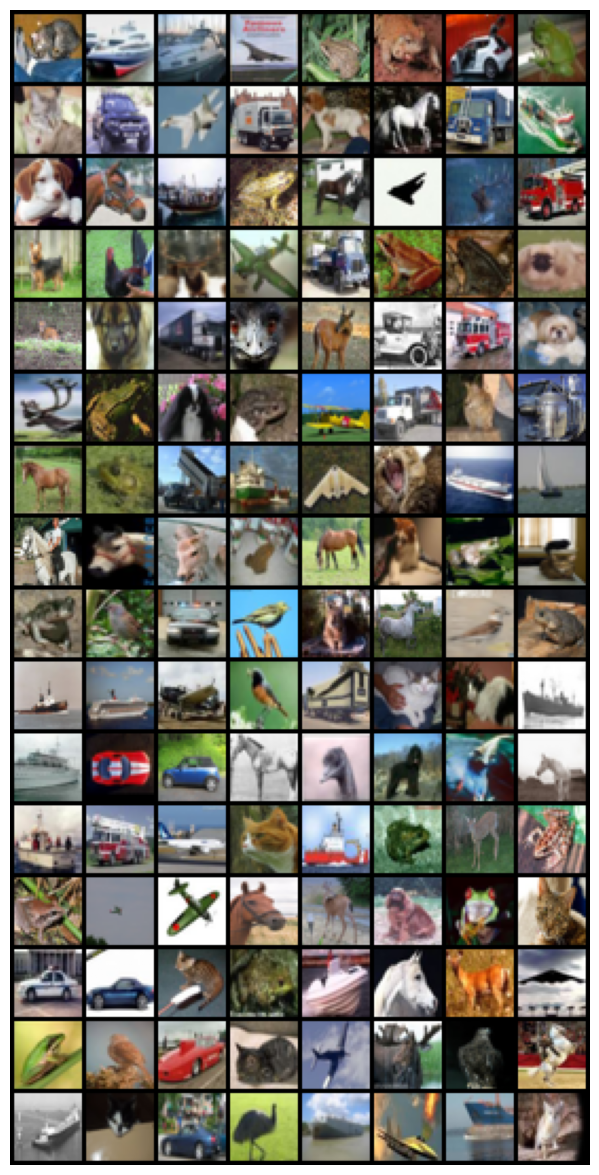

In [3]:
# Retrieve a batch of samples from the test data loader
samples, _ = next(iter(loader_test))

# Move the samples to CPU if they were on a GPU
samples = samples.cpu()

# Denormalize the samples, arrange them into a grid and return the grid as a single image
# `make_grid` creates a grid of images from the batch, with 8 images per row, 2 pixels of padding between images
# `denorm` function is used to revert the normalization process, bringing image pixel values back to [0,1] range
samples = make_grid(denorm(samples), nrow=8, padding=2, normalize=False,
                        scale_each=False, pad_value=0)

# Set up a figure for plotting with size 15x15 inches
plt.figure(figsize = (15,15))

# Disable axis since we are displaying an image grid, not plotting a graph
plt.axis('off')

# Display the grid of images using the `show` function
# The `show` function handles the conversion of the tensor to a format suitable for plotting
# with `matplotlib` and then displays it
show(samples)


In [4]:
# Number of complete passes through the training dataset.
num_epochs = 100

# Learning rate for the Generator: influences how quickly it updates weights.
learning_rate_G = 0.0004

# Learning rate for the Discriminator: influences its weight updates speed.
learning_rate_D = 0.0002

# Size of the random input vector for the Generator, affecting output diversity.
latent_vector_size = 32


In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Define the generator's architecture using a sequential model.
        self.generator = nn.Sequential(
            # First layer: Deconvolution, BatchNorm, and ReLU activation. Expands the latent vector.
            nn.ConvTranspose2d(latent_vector_size, 192, 4, 1, 0, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
            # Second layer: Deconvolution, BatchNorm, and ReLU activation. Further upsampling.
            nn.ConvTranspose2d(192, 96, 4, 2, 1, bias=False),
            nn.BatchNorm2d(96),
            nn.ReLU(True),
            # Third layer: Deconvolution, BatchNorm, and ReLU activation. Continues upsampling.
            nn.ConvTranspose2d(96, 48, 4, 2, 1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU(True),
            # Output layer: Deconvolution to generate final image output with 3 channels (RGB), using Tanh.
            nn.ConvTranspose2d(48, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        # Forward pass through the generator network.
        out = self.generator(x)
        return out

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # Define the discriminator's architecture using a sequential model.
        self.discriminator = nn.Sequential(
            # First layer: Convolution, BatchNorm, and LeakyReLU activation. Begins feature extraction.
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, True),
            # Second layer: Convolution, BatchNorm, and LeakyReLU activation. Further downsampling.
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, True),
            # Third layer: Convolution, BatchNorm, and LeakyReLU activation. Continues feature extraction.
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, True),
            # Output layer: Convolution to produce a single output prediction, using Sigmoid.
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Forward pass through the discriminator network, flattening output for binary classification.
        out = self.discriminator(x).view(-1, 1).squeeze(1)
        return out


In [6]:
def weights_init(m):
    # Get the name of the module's class to determine the type of layer.
    classname = m.__class__.__name__

    # Initialize weights for convolutional layers.
    if classname.find('Conv') != -1:
        # Kaiming normalization: good for layers with ReLU.
        torch.nn.init.kaiming_normal_(m.weight)
        # Zero initialization for biases, if present.
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

    # Initialize weights for batch normalization layers.
    elif classname.find('BatchNorm') != -1:
        # Normal distribution for weights, mean=1, std=0.02.
        m.weight.data.normal_(1.0, 0.02)
        # Zero initialization for biases.
        m.bias.data.fill_(0)


In [7]:
# Enable custom weight initialization.
use_weights_init = True

# Initialize Generator, move to device, and apply weight initialization if enabled.
model_G = Generator().to(device)
if use_weights_init:
    model_G.apply(weights_init)
# Count Generator's trainable parameters.
params_G = sum(p.numel() for p in model_G.parameters() if p.requires_grad)
# Display Generator parameters and architecture.
print("Total number of parameters in Generator is: {}".format(params_G))
print(model_G)
print('\n')

# Initialize Discriminator, move to device, and apply weight initialization if enabled.
model_D = Discriminator().to(device)
if use_weights_init:
    model_D.apply(weights_init)
# Count Discriminator's trainable parameters.
params_D = sum(p.numel() for p in model_D.parameters() if p.requires_grad)
# Display Discriminator parameters and architecture.
print("Total number of parameters in Discriminator is: {}".format(params_D))
print(model_D)
print('\n')

# Display total parameters across both models.
print("Total number of parameters is: {}".format(params_G + params_D))


Total number of parameters in Generator is: 469920
Generator(
  (generator): Sequential(
    (0): ConvTranspose2d(32, 192, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(192, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(96, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(48, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


Total number of parameters in Discriminator is: 663424
Discriminator(
  (discriminator): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), paddin

In [8]:
# Instantiate binary cross-entropy loss with mean reduction.
crit = nn.BCELoss(reduction='mean')

# Define the loss function for model output and target labels.
def loss_function(out, label):
    # Calculate and return the loss using BCELoss.
    loss = crit(out, label)
    return loss


In [9]:
# Initialize Adam optimizers for both Discriminator and Generator with specific learning rates and betas.
optimizerD = torch.optim.Adam(model_D.parameters(), betas=(0.5, 0.999), lr=learning_rate_D)
optimizerG = torch.optim.Adam(model_G.parameters(), betas=(0.5, 0.999), lr=learning_rate_G)

# Set up learning rate schedulers for both optimizers, reducing the learning rate by 5% after specified epochs.
schedulerD = torch.optim.lr_scheduler.StepLR(optimizerD, gamma=0.95, step_size=1)  # For Discriminator, every epoch.
schedulerG = torch.optim.lr_scheduler.StepLR(optimizerG, gamma=0.95, step_size=2)  # For Generator, every 2 epochs.


In [10]:
# Generate a batch of latent vectors to use as fixed input for generating samples; helps visualize progress.
fixed_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)

# Define labels for real and fake images used during training.
real_label = 1  # Label for real images.
fake_label = 0  # Label for fake images generated by the Generator.


In [11]:
train_losses_generator = []
train_losses_discriminator = []

for epoch in range(num_epochs):
    epoch_loss_discriminator = 0
    epoch_loss_generator = 0

    for i, data in enumerate(loader_train, 0):
        model_D.zero_grad()
        current_batch = data[0].to(device)
        batch_size = current_batch.size(0)
        label = torch.full((batch_size,), real_label*0.9, device=device, dtype=torch.float)

        # Train with real
        out_real = model_D(current_batch)
        loss_D_real = loss_function(out_real, label)
        loss_D_real.backward()
        D_x = out_real.mean().item()

        # Train with fake
        noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
        fake = model_G(noise)
        label.fill_(fake_label)
        out_fake = model_D(fake.detach())
        loss_D_fake = loss_function(out_fake, label)
        loss_D_fake.backward()
        D_G_z1 = out_fake.mean().item()

        optimizerD.step()
        loss_discriminator = loss_D_real + loss_D_fake
        epoch_loss_discriminator += loss_discriminator.item()

        model_G.zero_grad()
        label.fill_(real_label)
        output = model_D(fake)
        loss_G = loss_function(output, label)
        loss_G.backward()
        D_G_z2 = output.mean().item()

        optimizerG.step()
        epoch_loss_generator += loss_G.item()

        if i % 100 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(loader_train)}] '
                  f'Loss_D: {loss_discriminator:.4f} Loss_G: {loss_G:.4f} '
                  f'D(x): {D_x:.4f} D(G(z1)): {D_G_z1:.4f} D(G(z2)): {D_G_z2:.4f}')

    train_losses_discriminator.append(epoch_loss_discriminator / len(loader_train))
    train_losses_generator.append(epoch_loss_generator / len(loader_train))

    if epoch == 0:
        save_image(denorm(current_batch.cpu()).float(), '/content/DG_Assignments-2/CIFAR10_GAN/real_samples.png')
    with torch.no_grad():
        fake = model_G(fixed_noise)
        save_image(denorm(fake.cpu()).float(), f'/content/DG_Assignments-2/CIFAR10_GAN/fake_samples_epoch_{epoch:03d}.png')

# Save models
torch.jit.save(torch.jit.trace(model_G, (fixed_noise)), '/content/DG_Assignments-2/CIFAR10_GAN/GAN_G_model.pth')
torch.jit.save(torch.jit.trace(model_D, (fake)), '/content/DG_Assignments-2/CIFAR10_GAN/GAN_D_model.pth')


[0/100][0/383] Loss_D: 1.5167 Loss_G: 1.6521 D(x): 0.6098 D(G(z1)): 0.5582 D(G(z2)): 0.2266
[0/100][100/383] Loss_D: 0.4722 Loss_G: 4.1589 D(x): 0.7949 D(G(z1)): 0.0592 D(G(z2)): 0.0192
[0/100][200/383] Loss_D: 0.5487 Loss_G: 3.0662 D(x): 0.7819 D(G(z1)): 0.1103 D(G(z2)): 0.0540
[0/100][300/383] Loss_D: 0.4851 Loss_G: 3.0365 D(x): 0.8290 D(G(z1)): 0.0998 D(G(z2)): 0.0540
[1/100][0/383] Loss_D: 0.7196 Loss_G: 4.2089 D(x): 0.8589 D(G(z1)): 0.2705 D(G(z2)): 0.0198
[1/100][100/383] Loss_D: 0.8144 Loss_G: 2.2850 D(x): 0.6030 D(G(z1)): 0.1792 D(G(z2)): 0.1169
[1/100][200/383] Loss_D: 0.7626 Loss_G: 2.1349 D(x): 0.6800 D(G(z1)): 0.2158 D(G(z2)): 0.1426
[1/100][300/383] Loss_D: 0.7068 Loss_G: 3.1007 D(x): 0.7532 D(G(z1)): 0.2174 D(G(z2)): 0.0575
[2/100][0/383] Loss_D: 0.7263 Loss_G: 1.9895 D(x): 0.6341 D(G(z1)): 0.1042 D(G(z2)): 0.1685
[2/100][100/383] Loss_D: 0.7486 Loss_G: 2.0127 D(x): 0.6915 D(G(z1)): 0.2074 D(G(z2)): 0.1526
[2/100][200/383] Loss_D: 0.7716 Loss_G: 2.4870 D(x): 0.7213 D(G(z1

In [12]:
!pip install torchvision

In [13]:
import torchvision

In [14]:
input_noise = torch.randn(128, 100, 1, 1)

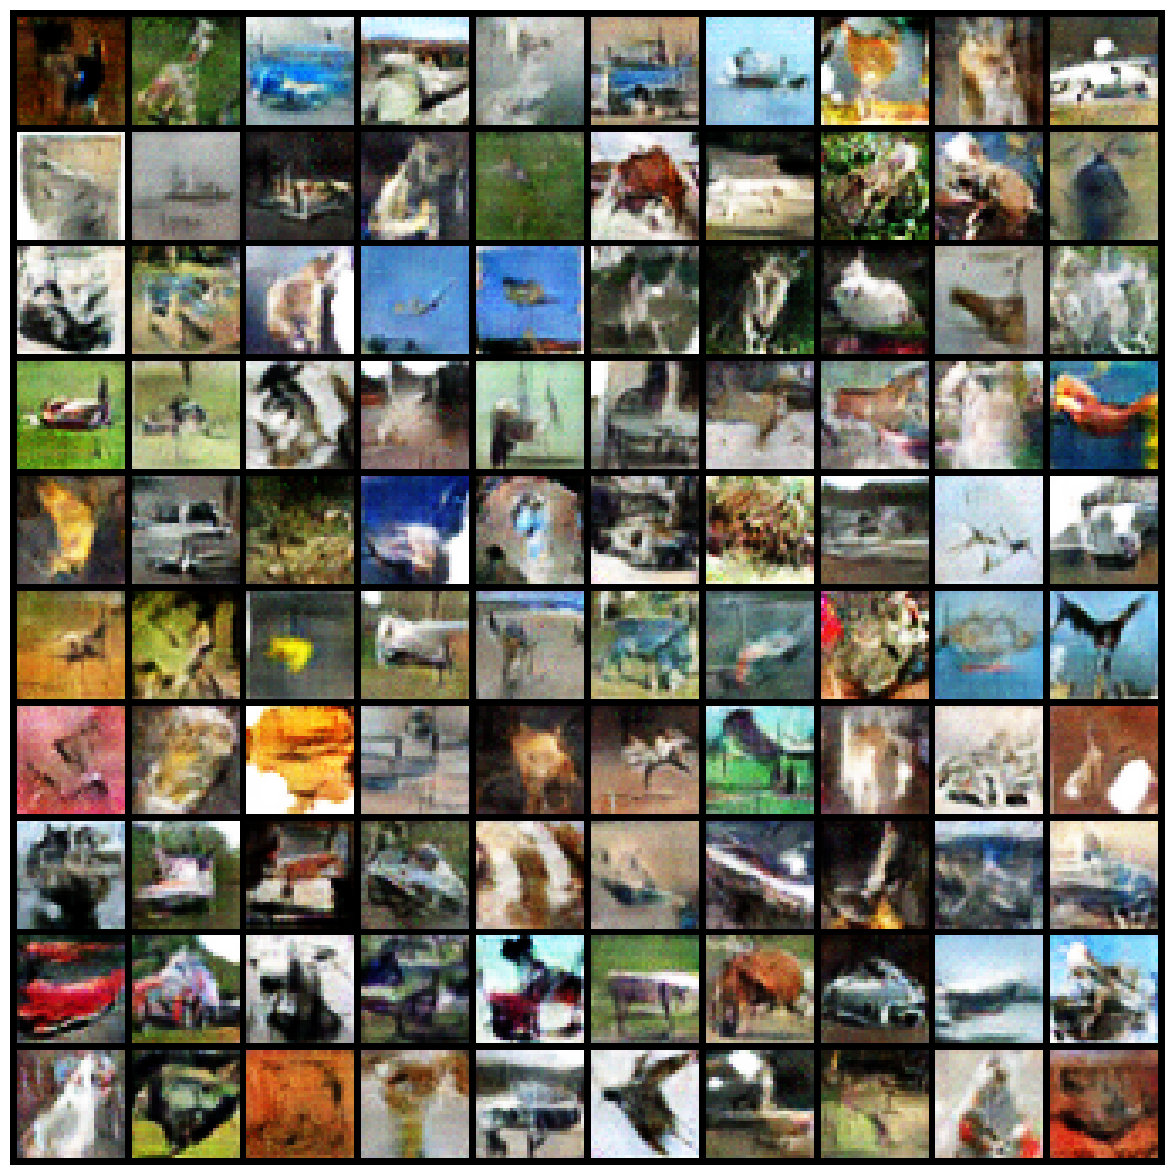

In [15]:
# Assuming `model_G` is your Generator model and `fixed_noise` is a batch of latent vectors.
# Ensure `model_G` is in evaluation mode to deactivate dropout or batch norm layers during inference.
model_G.eval()

# Generate a batch of images using the Generator.
# `fixed_noise` should be a tensor of shape [batch_size, latent_vector_size, 1, 1] and already on the correct device.
with torch.no_grad():
    generated = model_G(fixed_noise)

# Now you can use `generated` in the make_grid function.
import torchvision
generated_grid = torchvision.utils.make_grid(denorm(generated)[:100], nrow=10, padding=2, normalize=True,
                                             scale_each=False, pad_value=0)

# Display the generated grid of images.
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(generated_grid.permute(1, 2, 0).cpu().numpy()) # Adjusting the channel order for matplotlib


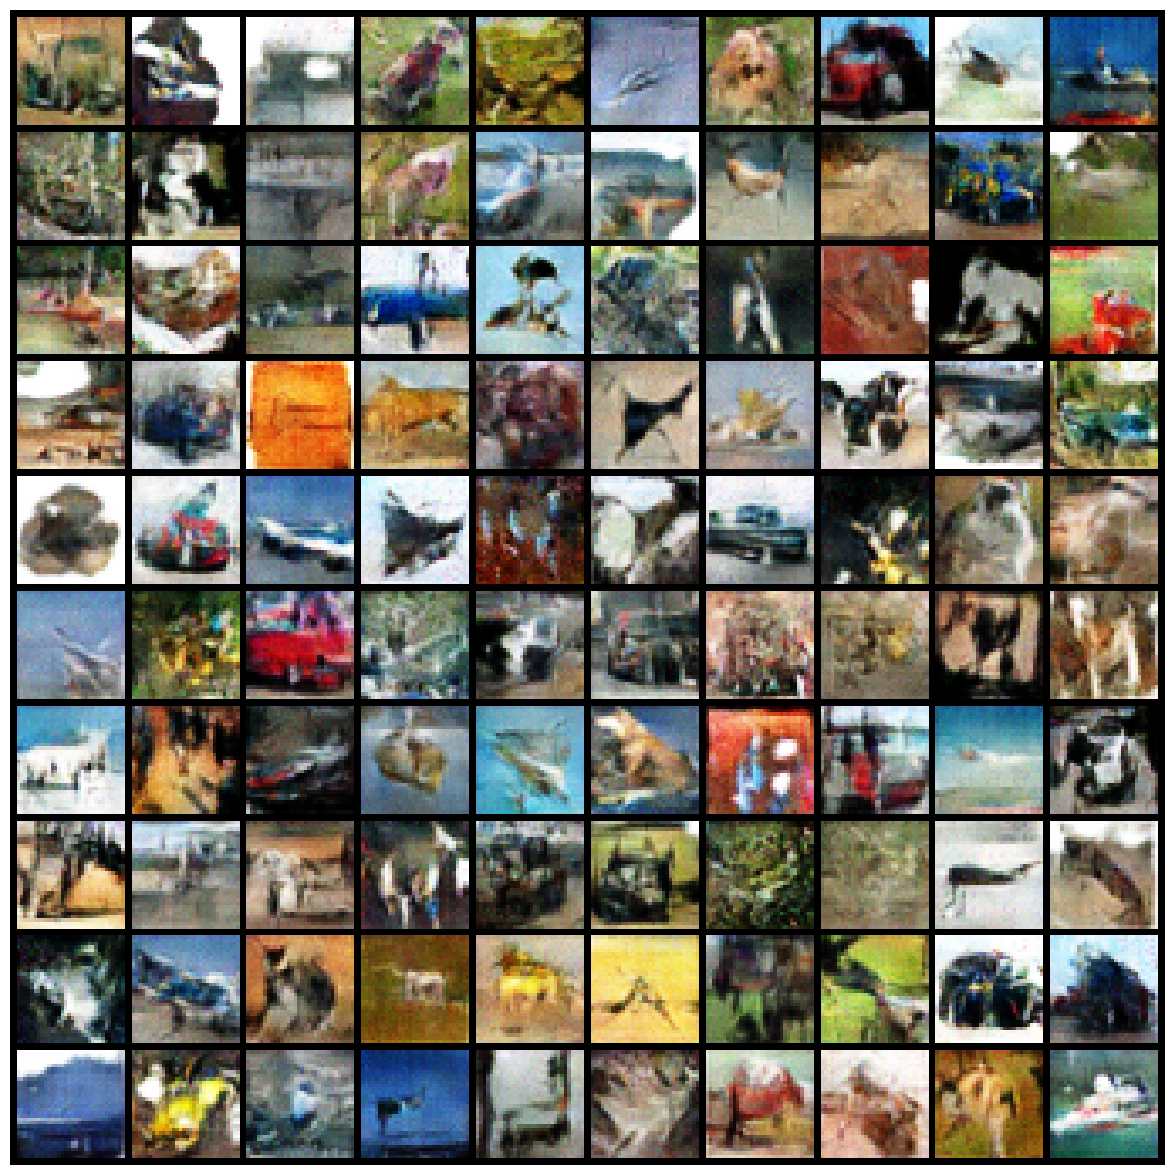

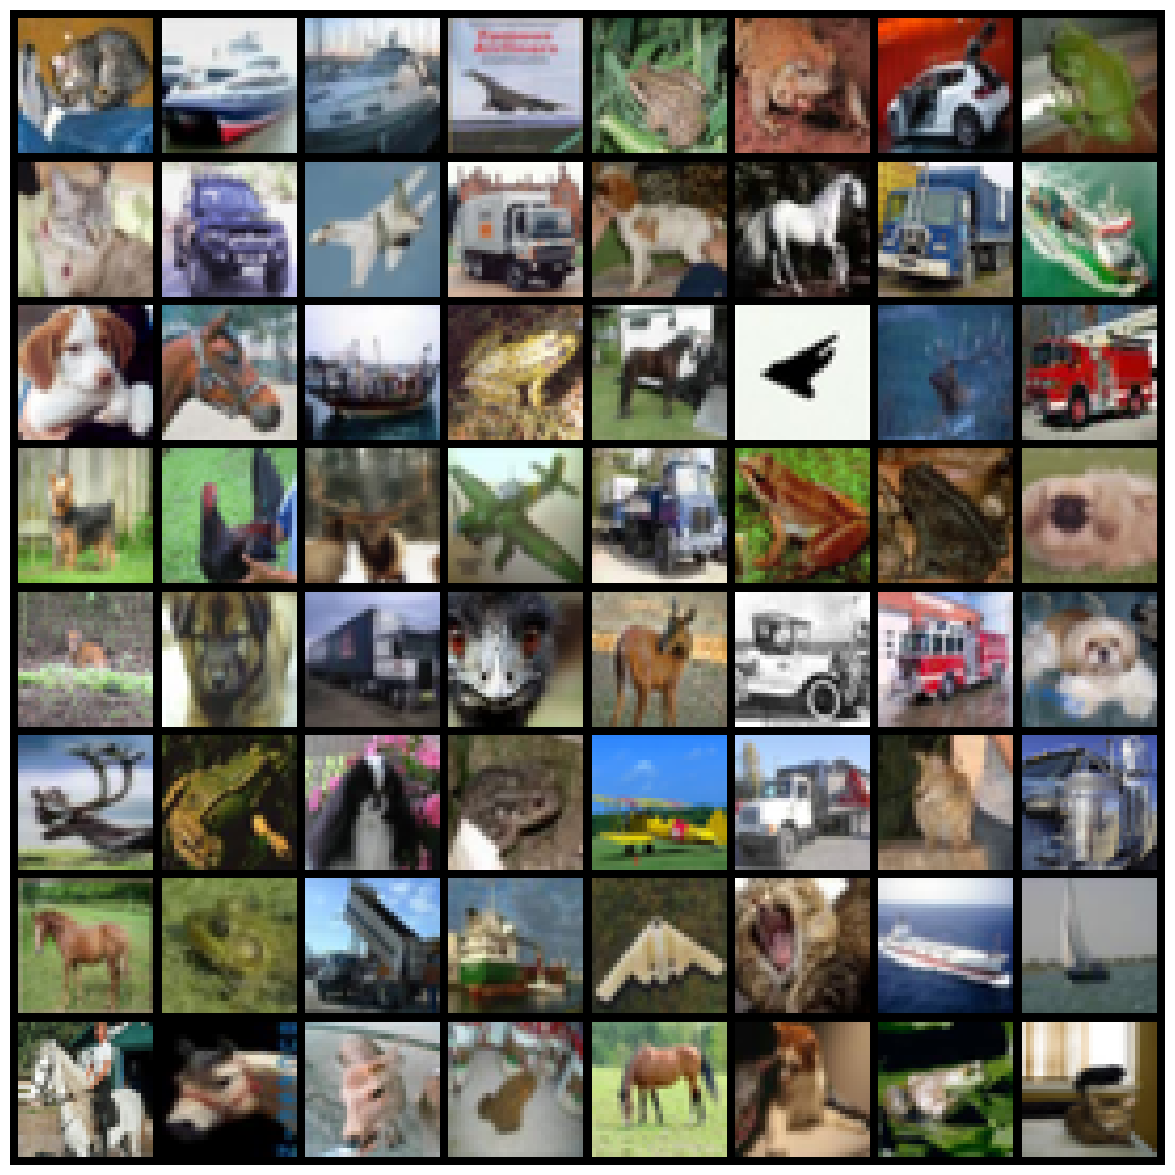

In [16]:


import torchvision
import matplotlib.pyplot as plt
from torchvision.utils import save_image
# Correct latent_vector_size to match the generator's expectation.
latent_vector_size = 32  # The size expected by your generator's first layer.

# Assuming you're generating noise for a batch size of 128.
batch_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate input noise with the correct size.
input_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)

# Now, generating images with the corrected noise size should work without errors.
model_G.eval()  # Set the model to evaluation mode.
with torch.no_grad():
    generated = model_G(input_noise).cpu()



# Apply denormalization to the generated images and create a grid.
generated_grid = torchvision.utils.make_grid(denorm(generated)[:100], nrow=10, padding=2, normalize=True, pad_value=0)

# Save the grid of generated images.
save_image(generated_grid, '/content/DG_Assignments-2/CIFAR10_GAN/final.png')

# Display the grid of generated images.
plt.figure(figsize=(15, 15))
plt.axis('off')  # Remove axes for better visualization.
plt.imshow(generated_grid.permute(1, 2, 0))  # Adjust channel order for plotting.
plt.show()

# Get a batch of real images from the test loader for comparison.
it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:64, :, :, :].cpu()  # Select a subset and move to CPU.

# Create a grid of the real images.
real_images_grid = torchvision.utils.make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=True, pad_value=0)

# Display the grid of real images for comparison.
plt.figure(figsize=(15, 15))
plt.axis('off')  # Remove axes for better visualization.
plt.imshow(real_images_grid.permute(1, 2, 0))  # Adjust channel order for plotting.
plt.show()


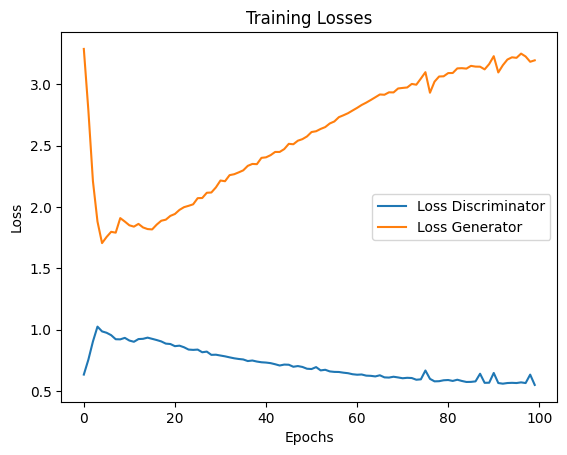

In [17]:
import matplotlib.pyplot as plt

plt.plot(list(range(0, np.array(train_losses_discriminator).shape[0])), np.array(train_losses_discriminator), label='Loss Discriminator')
plt.plot(list(range(0, np.array(train_losses_generator).shape[0])), np.array(train_losses_generator), label='Loss Generator')

plt.title('Training Losses')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()